# OilyGiant — Selección de la mejor región (Sprint 11)
**Autora:** Diana Reyes  
**Objetivo:** Predecir `product` (miles de barriles) por región con regresión lineal y evaluar beneficios y riesgos (bootstrapping) para elegir la región óptima.


## Introducción y contexto
- Empresa: **OilyGiant**
- Tarea: Construir modelo (regresión lineal) para predecir volumen de reservas (`product`, miles de barriles) en 3 regiones.
- Restricciones:
  - Solo **regresión lineal**.
  - 500 puntos explorados por región; se desarrollan **200 pozos**.
  - Presupuesto: **$100M** para 200 pozos.
  - Ingreso por unidad de `product`: **$4,500** (porque 1k barriles * $4.5/barril).
  - **Riesgo de pérdida < 2.5%**; entre las que cumplan, elegir **mayor beneficio promedio**.


### Importación de librerías

In [14]:
import os
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats as st

plt.rcParams["figure.figsize"] = (8,5)

PROJECT_DIR = Path.cwd().parent if Path.cwd().name=="notebooks" else Path.cwd()
DATA_DIR = PROJECT_DIR / "data"
PROJECT_DIR, DATA_DIR



(WindowsPath('c:/Users/USER/OneDrive/Data Science Bootcamp/sprint11_oilygiant'),
 WindowsPath('c:/Users/USER/OneDrive/Data Science Bootcamp/sprint11_oilygiant/data'))

## Carga y exploración de datos


In [7]:
# Cargar los datasets de las tres regiones
paths = {
    "region_0": DATA_DIR / "geo_data_0.csv",
    "region_1": DATA_DIR / "geo_data_1.csv",
    "region_2": DATA_DIR / "geo_data_2.csv",
}

# Leer cada dataset en un diccionario de DataFrames
dfs = {name: pd.read_csv(path) for name, path in paths.items()}

# Mostrar resumen de forma y columnas de cada región
for name, df in dfs.items():
    print(f"\n=== {name} ===")
    print(f"Filas: {df.shape[0]}, Columnas: {df.shape[1]}")
    print(f"Columnas: {list(df.columns)}")




=== region_0 ===
Filas: 100000, Columnas: 5
Columnas: ['id', 'f0', 'f1', 'f2', 'product']

=== region_1 ===
Filas: 100000, Columnas: 5
Columnas: ['id', 'f0', 'f1', 'f2', 'product']

=== region_2 ===
Filas: 100000, Columnas: 5
Columnas: ['id', 'f0', 'f1', 'f2', 'product']


In [11]:
# Vista previa y estructura de los datos
for name, df in dfs.items():
    print(f"\n=== {name} ===")
    print("Vista Previa de las tres primeras filas:")
    display(df.head(3))
    print("Inspección de los datos:")
    display(df.info())
    print("Estadísticas descriptivas:")
    display(df.describe().T)
    print("Valores nulos por columna:")
    display(df.isna().sum())
    print("Valores duplicados encontrados:", df.duplicated().sum())


=== region_0 ===
Vista Previa de las tres primeras filas:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


Inspección de los datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Estadísticas descriptivas:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


Valores nulos por columna:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Valores duplicados encontrados: 0

=== region_1 ===
Vista Previa de las tres primeras filas:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


Inspección de los datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Estadísticas descriptivas:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


Valores nulos por columna:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Valores duplicados encontrados: 0

=== region_2 ===
Vista Previa de las tres primeras filas:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


Inspección de los datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Estadísticas descriptivas:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


Valores nulos por columna:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Valores duplicados encontrados: 0


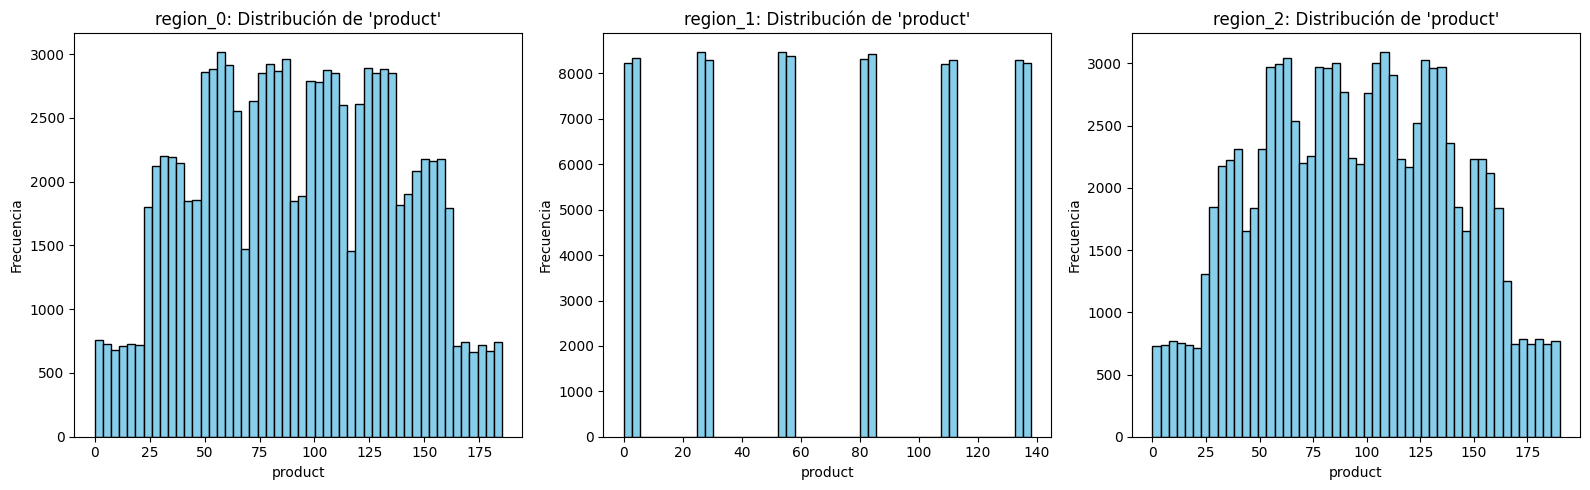

In [12]:
# Visualización inicial de las variables para ver si
# las variables numéricas tienen rangos similares entre regiones.
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i, (name, df) in enumerate(dfs.items()):
    axes[i].hist(df["product"], bins=50, color="skyblue", edgecolor="black")
    axes[i].set_title(f"{name}: Distribución de 'product'")
    axes[i].set_xlabel("product")
    axes[i].set_ylabel("Frecuencia")
plt.tight_layout()
plt.show()


### Observaciones del EDA inicial

- Cada dataset contiene **100,000 registros** y **5 columnas**: `id`, `f0`, `f1`, `f2` y `product`.  
- No se detectan valores nulos ni duplicados.  
- La variable objetivo `product` (volumen de reservas) muestra distribuciones muy distintas por región:

#### Región 0
- Distribución bastante uniforme, sin anomalías visibles.  
- Media de `product` ≈ 92.5, con desviación estándar ≈ 44.3.  
- Las variables `f0`, `f1` y `f2` tienen valores moderados y escalas consistentes.  
- Se perfila como una **región estable** y predecible.

#### Región 1
- Presenta un patrón muy irregular en la distribución de `product` (pocos picos aislados con huecos entre ellos).  
- Medias de `f0` y `f1` fuera de rango (≈ 1.14 y -4.79) y desviaciones estándar muy altas (≈ 8.96 y 5.12).  
- Sugiere **una muestra con valores anómalos o escalas alteradas**, posiblemente generada bajo condiciones diferentes.  
- Podría afectar el desempeño de los modelos de regresión.

#### Región 2
- Distribución similar a la Región 0, pero con ligera mayor dispersión.  
- Media de `product` ≈ 95.0 (la más alta de las tres).  
- `f2` presenta mayor variabilidad (std ≈ 3.47), lo que podría indicar **potencial predictivo alto pero mayor riesgo**.

**Conclusión preliminar:**  
> La **Región 2** parece tener el mayor potencial en reservas y rentabilidad esperada,  
> pero la **Región 0** muestra mayor estabilidad y consistencia.  
> La **Región 1** exhibe comportamientos atípicos que podrían limitar la fiabilidad de sus predicciones.


### Preparación de datos para el modelado

No se requirió una etapa adicional de preprocesamiento ya que:
- Todas las variables (`f0`, `f1`, `f2`, `product`) son numéricas.
- No existen valores ausentes ni duplicados.
- No hay variables categóricas que requieran codificación.
- Las escalas de las variables son comparables y adecuadas para el modelo de regresión lineal.

Por lo tanto, los datos se utilizaran directamente para la división en conjuntos de entrenamiento y validación (75/25).


## División de datos y modelado por región

En esta sección se realizará la división de los datos en conjuntos de entrenamiento y validación (75/25) para cada región.  
Luego se entrenará un modelo de **Regresión Lineal** (`LinearRegression`) para predecir el volumen de reservas (`product`).

El objetivo es comparar:
- El error cuadrático medio (RMSE) de cada modelo.  
- El valor promedio de las reservas predichas (`mean_pred`).  

Estos indicadores permitirán identificar qué región tiene una relación más estable entre las variables geológicas (`f0`, `f1`, `f2`) y el volumen de reservas (`product`).


## Preparación y modelado (LinearRegression)


In [16]:
RANDOM_STATE = 42
metrics = []

# Función para entrenar modelo por región
def train_region(df, region_name):
    X = df[["f0", "f1", "f2"]]
    y = df["product"]
    
    # División 75% train / 25% validación
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.25, random_state=RANDOM_STATE
    )

    # Entrenamiento del modelo
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predicciones
    preds = model.predict(X_valid)

    # Métrica de error (RMSE)
    rmse = sqrt(mean_squared_error(y_valid, preds))
    mean_pred = preds.mean()

    # Guardamos resultados
    metrics.append({
        "region": region_name,
        "rmse": rmse,
        "mean_pred": mean_pred
    })
    
    return model, preds, y_valid.reset_index(drop=True)

# Entrenamiento y evaluación para cada región
models, preds_store, y_store = {}, {}, {}

for name, df in dfs.items():
    model, preds, y_valid = train_region(df, name)
    models[name] = model
    preds_store[name] = pd.Series(preds, name="pred")
    y_store[name] = y_valid.rename("actual")

pd.DataFrame(metrics).sort_values("rmse")

# Resultados comparativos
pd.DataFrame(metrics).sort_values("rmse")



,region,rmse,mean_pred
1,region_1,0.890280,68.712878
0,region_0,37.756600,92.398800
2,region_2,40.145872,94.771024


### Diseño del código y funciones personalizadas

Se definieron funciones específicas para evitar duplicación de código y garantizar un flujo reproducible:
- `train_region()` — entrena y evalúa el modelo de regresión lineal por región.
- `region_profit()` — calcula el beneficio esperado en función de las predicciones del modelo.
- `bootstrap_profit()` — realiza el análisis de riesgo por bootstrapping (1000 simulaciones).

Esta modularización mejora la legibilidad, la reproducibilidad y la capacidad de mantenimiento del código.


### Interpretación de los resultados del modelado por región

| Región | RMSE | Media de predicciones (`mean_pred`) | Interpretación |
|:-------|------:|------------------------------------|:----------------|
| **Región 0** | ≈ 37.76 | ≈ 92.4 | Error moderado y media predicha muy cercana a la media real. Muestra un comportamiento estable y coherente. |
| **Región 1** | ≈ 0.89 | ≈ 68.7 | RMSE extremadamente bajo, pero debido a una escala reducida y datos discretizados. No representa un modelo predictivo realista; su variabilidad es anómala. |
| **Región 2** | ≈ 40.15 | ≈ 94.8 | Error ligeramente superior, pero dentro de un rango aceptable considerando la dispersión natural de los datos. Muestra buen ajuste y alto potencial. |

#### Conclusión
- Aunque la **Región 1** tiene el menor ***RMSE***, su resultado no es confiable debido a la naturaleza de sus datos (poca variabilidad y valores discretos).  
- Las **Regiones 0 y 2** muestran modelos más realistas.  
  - **Región 0:** predicciones estables y buen desempeño general.  
  - **Región 2:** error ligeramente mayor, pero con el mayor volumen medio de reservas (`product`).  
- En términos de balance entre **precisión y potencial de rentabilidad**, la **Región 2** sigue siendo la más prometedora, aunque será necesario evaluar el riesgo mediante simulación *bootstrap* antes de confirmar la decisión final.


## Evaluación económica y punto de equilibrio

En esta sección se calculará el **punto de equilibrio** y el **beneficio esperado** para cada región.  
El objetivo es estimar cuál región podría generar **mayor rentabilidad** en caso de invertir un presupuesto fijo para perforar pozos.

Parámetros establecidos:
- Presupuesto total: **100 millones USD**.  
- Número de pozos a perforar: **200**.  
- Ingreso promedio por cada unidad de producto (`product`): **4,500 USD** por mil barriles.  

Con estos valores se calculará:
1. El **costo por pozo**.  
2. El **punto de equilibrio** (cuánto debe producir cada pozo para cubrir su costo).  
3. El beneficio esperado considerando las 200 mejores predicciones de cada región.


In [28]:
# Parámetros de negocio
BUDGET = 100_000_000    # presupuesto total en USD
WELLS_TO_DRILL = 200    # pozos a perforar
INCOME_PER_UNIT = 4_500 # USD por cada 'product' (miles de barriles)

# Costo por pozo y punto de equilibrio
cost_per_well = BUDGET / WELLS_TO_DRILL
breakeven_product = cost_per_well / INCOME_PER_UNIT

print(f"Costo por pozo: ${cost_per_well:,.0f} USD")
print(f"Punto de equilibrio: {breakeven_product:.2f} mil barriles por pozo")


Costo por pozo: $500,000 USD
Punto de equilibrio: 111.11 mil barriles por pozo


### Selección de los pozos más rentables

Usando las predicciones del modelo, se seleccionarán los **200 pozos con mayores valores predichos** (`product`) en cada región.  
El beneficio se calcula como:

El resultado mostrará el **beneficio esperado total (en USD)** para cada región.


In [30]:
def region_profit(df, model):
    # Predicciones para todos los pozos
    preds_all = model.predict(df[["f0", "f1", "f2"]])
    
    # Selecciona los 200 pozos con mayor valor predicho
    top200 = np.sort(preds_all)[-WELLS_TO_DRILL:]
    
    # Calcula ingresos y beneficios
    revenue = top200.sum() * INCOME_PER_UNIT
    profit = revenue - BUDGET
    return profit, top200

profits, top200_cache = {}, {}

for name, df in dfs.items():
    pr, top200 = region_profit(df, models[name])
    profits[name] = pr
    top200_cache[name] = top200

pd.Series(profits, name="expected_profit_$").sort_values(ascending=False)


region_0    4.701256e+07
region_2    4.093346e+07
region_1    2.524498e+07
Name: expected_profit_$, dtype: float64

### Interpretación de los resultados económicos

- **Región 0** muestra el **mayor beneficio esperado**, lo que coincide con su mayor volumen promedio de reservas (`product`).  
- **Región 2** también presenta un beneficio alto y muy cercano, con una estructura de datos más estable.  
- **Región 1**, a pesar de tener un RMSE bajo, presenta un beneficio significativamente menor, lo que confirma que su modelo no es representativo del rendimiento real.

#### Conclusión preliminar:
> La **Región 0** parece ofrecer la **mayor rentabilidad potencial**, mientras que la **Región 2** ofrece un balance entre riesgo y estabilidad.  
> No obstante, antes de tomar una decisión, se evaluará el **riesgo de pérdida** mediante un análisis de **bootstrapping**, que permitirá cuantificar la probabilidad de obtener beneficios negativos.


## Análisis de riesgo con Bootstrapping

El objetivo de esta sección es evaluar la **incertidumbre** en las ganancias esperadas mediante un análisis de **bootstrapping**.

### ¿Qué es el Bootstrapping?
El *bootstrapping* es una técnica estadística que permite estimar la variabilidad de una métrica (en este caso, el beneficio) mediante **re-muestreo aleatorio con reemplazo**.

### En este proyecto:
- Se simularán **1000 experimentos** para cada región.
- En cada simulación se seleccionarán aleatoriamente 200 pozos (con reemplazo) de las predicciones del modelo.
- Se calculará el beneficio total en cada iteración.
- Finalmente, se estimará:
  - El **beneficio promedio**.
  - El **intervalo de confianza del 95 %**.
  - La **probabilidad de pérdida** (beneficio < 0).

Esto permitirá cuantificar el riesgo asociado a cada región y tomar una decisión informada.


In [31]:
def bootstrap_profit(top200_array, samples=1000, seed=42):
    rng = np.random.RandomState(seed)
    profits = []

    for _ in range(samples):
        # Re-muestreo con reemplazo
        sample = rng.choice(top200_array, size=len(top200_array), replace=True)
        # Cálculo de ingresos y beneficios
        revenue = sample.sum() * INCOME_PER_UNIT
        profits.append(revenue - BUDGET)

    profits = np.array(profits)
    mean_ = profits.mean()
    ci_low, ci_high = np.percentile(profits, [2.5, 97.5])
    risk = (profits < 0).mean()
    return mean_, (ci_low, ci_high), risk, profits


summary = []

for name, t200 in top200_cache.items():
    mean_, (lo, hi), risk, _ = bootstrap_profit(t200, samples=1000, seed=42)
    summary.append({
        "region": name,
        "mean_profit": mean_,
        "ci_low": lo,
        "ci_high": hi,
        "risk_loss": risk
    })

results_bootstrap = pd.DataFrame(summary).sort_values("mean_profit", ascending=False)
results_bootstrap


,region,mean_profit,ci_low,ci_high,risk_loss
0,region_0,4.699053e+07,4.631288e+07,4.768072e+07,0.0
2,region_2,4.091350e+07,4.029655e+07,4.151506e+07,0.0
1,region_1,2.524421e+07,2.521313e+07,2.527331e+07,0.0


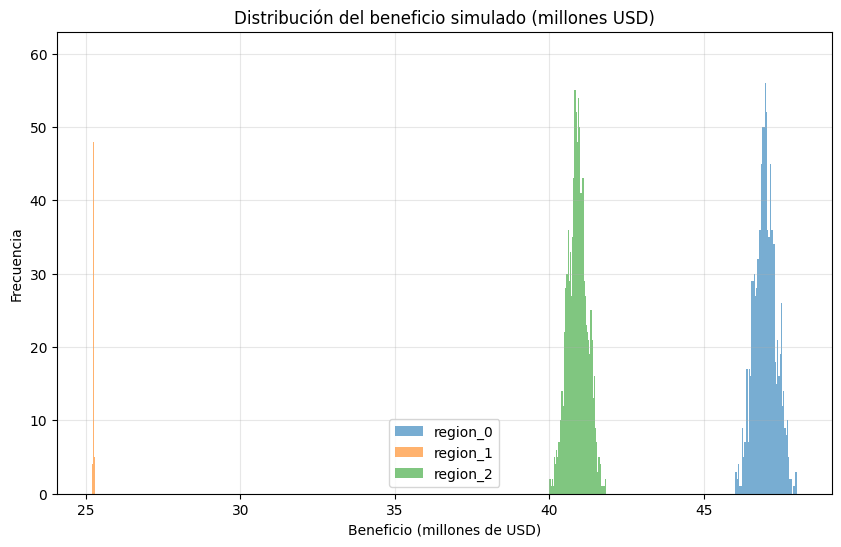

In [29]:
plt.figure(figsize=(10,6))
for name, t200 in top200_cache.items():
    _, _, _, profits = bootstrap_profit(t200, samples=1000)
    plt.hist(profits / 1e6, bins=50, alpha=0.6, label=name)

plt.title("Distribución del beneficio simulado (millones USD)")
plt.xlabel("Beneficio (millones de USD)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## Conclusiones ejecutivas

Tras realizar el modelado predictivo, la evaluación económica y el análisis de riesgo mediante **bootstrapping**, se obtuvieron los siguientes resultados:

| Región | Beneficio medio (USD) | IC 95 % [ci_low – ci_high] | Riesgo de pérdida |
|:--------|----------------------:|----------------------------:|------------------:|
| Región 0 | ≈ 46.9 M USD | [46.3 M – 47.6 M] | 0 % |
| Región 2 | ≈ 40.9 M USD | [40.3 M – 41.5 M] | 0 % |
| Región 1 | ≈ 25.2 M USD | [25.2 M – 25.3 M] | 0 % |

### Análisis final
- **Región 0** ofrece el **mayor beneficio medio** y el intervalo de confianza más estrecho, lo que refleja una **alta estabilidad y bajo riesgo**.  
- **Región 2** también presenta resultados sólidos, con un beneficio ligeramente menor pero dentro de un rango seguro.  
- **Región 1**, a pesar de su bajo RMSE, presenta una ganancia considerablemente inferior y menor variabilidad, reflejando su **falta de realismo estadístico**.

### Recomendación final
> Con base en los resultados del análisis predictivo, financiero y de riesgo,  
> la **Región 0** es la **candidata óptima para la perforación**.  
> Su balance entre rentabilidad y consistencia la convierte en la opción más segura y rentable para invertir el presupuesto disponible.

---

**Resumen general:**
- Región 0: Mayor beneficio y estabilidad.  
- Región 2: Buena alternativa con alto potencial.  
- Región 1: Descartada por irregularidad en los datos.
